# ESA - Collision Avoidance Challenge

## Introduction

As space debris becomes an increasingly pressing issue, the European Space Agency (ESA) initiated the "Collision Avoidance Challenge" in 2019 to tackle potential collisions in orbit through data analysis and artificial intelligence. For an in-depth look at the competition and its aims, please refer to the official competition website listed below, and check out the ESA's post-competition publication "Spacecraft Collision Avoidance Challenge: Design and Results of a Machine Learning Competition" available in this project's repository (article.pdf) :
- https://kelvins.esa.int/collision-avoidance-challenge/home/

The initial phase, documented in the "reproduce_solutions.ipynb" notebook, focused on reimplementing solutions from the ESA's publication. Expanding on this, the current notebook presents an alternative approach. Although the article notes that the use of machine learning methods might not be optimal, particularly due to the poor correlation between training and test datasets, we aim to further explore the potential of these techniques to see if we can surpass the reported error rates of 0.83 to 1.0 mentioned in the article. In this context, we are utilizing the LGBM algorithm, inspired by the article, but with adaptations to the methodology aimed at enhancing performance.

## Setup

We start by importing the necessary libraries for this project. All the dependencies required are listed in the ***requirements.txt*** file.

In [26]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from sklearn.metrics import fbeta_score, mean_squared_error, make_scorer, roc_auc_score
from sklearn.preprocessing import QuantileTransformer
from imblearn.over_sampling import SMOTE

import numpy as np
from lightgbm import LGBMRegressor

plt.style.use('seaborn-v0_8')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 200)
pd.options.mode.copy_on_write = True
warnings.simplefilter(action='ignore')

We then load the competition data into our environment, which can be retrieved directly from this repository in the ***data*** folder or from the following link:

- https://zenodo.org/records/4463683

Here, we aim to replicate the conditions of the competitors. Therefore, we use only the data contained in the ***kelvins_competition_data*** folder.

In [33]:
df_train_init = pd.read_csv(".\\data\\train_data.csv").sort_values(by=['event_id', 'time_to_tca'], ascending=[True, False])
X_test_init = pd.read_csv(".\\data\\test_data.csv").sort_values(by=['event_id', 'time_to_tca'], ascending=[True, False])
y_test_init = pd.read_csv(".\\data\\test_data_private.csv").sort_values(by=['event_id'])

## Metrics

Now, we define the metrics used in the competition, which will be the basis for replicating the results. Here are the formulas for these metrics:

The loss used in the competition is defined from two error metrics as follows, where $r$ corresponds to the final risk and $\hat{r}$ to the associated prediction:

$$\boxed{L(\hat{r}) = \frac{1}{F_2} MSE_{hr}(r, \hat{r})}$$

We then have:

$$MSE_{HR}(r, \hat{r}) = \frac{1}{N^*} \sum_{i=1}^N I_i(r_i - \hat{r}_i)^2$$

- $I_i = \begin{cases} 
1 & \text{if } r_i \geq -6, \\
0 & \text{else}.
\end{cases}$ , indicating whether the data belongs to the high-risk group $(1)$ or a low-risk group $(0)$
- $N^* = \sum_{i=1}^N I_i$ , representing the number of high-risk data points


And:

$$F_{\beta} = (1 + \beta^2) \frac{p \times q}{(\beta^2 \times p) + q}$$

- $p$ and $q$ corresponding respectively to precision and recall in binary classification, with our classes defined by $I$.

In summary, $MSE_{HR}$ represents an average distance calculated between predicted and real data, but only for the real high-risk data $(r \geq -6)$. $F_{\beta}$, on the other hand, represents a performance score in the classification of low and high-risk data, where the balance between precision and recall is adjusted according to the $\beta$ parameter: the larger $\beta$ is, the greater the weight of recall, and vice versa.

From these metrics, two essential points are to be noted:
- Since $MSE_{HR}$ is calculated only on the actual high-risk data, it will be in our interest to clip the value of data predicted as low risk by our models. This will have the effect of minimizing the $MSE_{HR}$, without impacting our $F_2$ score.
- We consider here the $F_2$ score, which therefore places more weight on false negatives than on false positives. It might then be interesting to bias the model to predict high-risk data more often, even when this is not the case, to limit false positives as much as possible.


In [34]:
def mse_hr(y_true, y_pred, clipped_value=-6.001):
    """
    Compute MSE_hr loss defined previously
    Integrate the clipping of low risk prediction.

    Parameters:
    - y_true (numpy array): ground truth (correct) target values.
    - y_pred (numpy array): estimated target values
    - clipped_value (float): value to clip predictions which are not predicted as high risk

    Returns:
    - error (float): the best value is 0.0
    """
    risk_category_true = np.where(y_true >= -6.00, 1, 0)
    y_true = y_true[risk_category_true == 1]
    y_pred = y_pred[risk_category_true == 1]

    y_pred_clipped = np.where(y_pred >= -6, y_pred, clipped_value)

    return mean_squared_error(y_true, y_pred_clipped)


def f2(y_true, y_pred):
    """
    Compute F2 score defined previously
    Integrate the class decision from y_true and y_pred.

    Parameters:
    - y_true (numpy array): ground truth (correct) target values.
    - y_pred (numpy array): estimated target values

    Returns:
    - score (float): the best value is 1.0
    """
    risk_category_true = np.where(y_true >= -6.00, 1, 0)
    risk_category_pred = np.where(y_pred >= -6.00, 1, 0)

    return fbeta_score(risk_category_true, risk_category_pred, beta=2)


def loss(y_true, y_pred):
    """
    Compute Loss defined previously

    Parameters:
    - y_true (numpy array): ground truth (correct) target values.
    - y_pred (numpy array): estimated target values

    Returns:
    - loss (float): the best value is 0.0
    """

    return 1/f2(y_true, y_pred) * mse_hr(y_true, y_pred)

## Method 1 - LGBM Pipeline

This first method aims to utilize the LGBM model, as previously applied in the article, and try to provide an implementation that surpasses the results achieved through traditional machine learning methods. To accomplish this, data manipulation is necessary because, as specified in the article, the correlation between train and test datasets is relatively low, and working directly with the intact datasets doesn't seem efficient.

In our approach, to improve the representativeness of the training, we will integrate the following steps presented in the following figure :

<img src="./images/lgbm_data_processing.png" alt="drawing" width="900"/>

- **Data Structure** : First, the data structure will remain the same as the one describe in the article : we will use the most recent CDMs with a $time\_to\_tca < 1$ as the target and the most recent CDM with $time\_to\_tca >= 2$ as the data point for a given event.

- **Feature Selection** : Here, instead of keeping almost all features as in the article, we will only keep the risk. This selection mirrors the LRP approach but allows a more flexible and complex utilization of the risk data point since we can find non-linearities. This targeted approach also helps in preventing overfitting, as it minimizes the risk of the model learning irrelevant variance from other features that would not be seen in the test set. In fact, we sacrifice a large part of the data to have a more generalizable dataset.

- **Data Processing and Augmentation** : The main change from the method in the article is that we will exclude all data presenting a risk of -30, as it is prone to overfitting and the distribution being clipped could induce bias. Furthermore, as our evaluations focus on high-risk data, we are not particularly interested in having a precise model for these data points. After excluding these data, we increase the number of high risk data ($risk >= -6.0) by using SMOTE algorithm. Thus, we extract synthetic data created from real samples to achieve a balance between events high risk and low risk events. In this way, we maximize the model's training on data more relevant to the test set (and therefore to useful real-world scenarios).

- **Prediction Mechanism** : Similar to the methodology used in the article, we aim to predict the difference in risk between the last available CDM and the risk to be predicted. This difference is then normalized by a QuantileTransformer in the same manner. This simplifies the training and helps extract a more homogeneous distribution of the data to be predicted.

In the cell below, we prepare the datasets in the specified format.

In [38]:
def extract_train_dataset(df):
    """
    Prepare the training dataset for the training of the LGMB model

    Parameters:
    - df (pandas DataFrame): Official training dataset unchanged downloaded from the competition site

    Returns:
    - X_train (pandas DataFrame): Training data
    - y_train (pandas DataFrame): Labels associated to the training data. Contains :
        - the target value (true_risk) which is the risk for the last tca available
        - the difference between the risk and the target value (diff_risk)
        - the class of the target value (class_risk)
    """

    keep_events = []

    # Keeping only the CDM that have a higher risk than -30
    df = df[df['risk'] > -30.0]

    # Select eligible events 
    for event in df['event_id'].unique():
        if (df[df['event_id'] == event]['time_to_tca'].min() < 1.0) & (len(df[(df['event_id'] == event) & (df['time_to_tca'] >= 2.0)]) >= 1):
            keep_events.append(event)
    df_interest = df[df['event_id'].isin(keep_events)]
    
    # Extract the target for each event
    y_train = df_interest.loc[df_interest.groupby('event_id')['time_to_tca'].idxmin()][['event_id', 'risk']]
    y_train.rename(columns={'risk':'true_risk'}, inplace=True)
    y_train.set_index('event_id', drop=True, inplace=True)
    
    # Extract the data for each event
    X_train = df_interest[df_interest['time_to_tca'] >= 2.0]
    X_train = X_train.loc[X_train.groupby('event_id')['time_to_tca'].idxmin()]
    X_train.set_index('event_id', drop=True, inplace=True)

    # Create additional targets
    y_train['diff_risk'] = y_train['true_risk'] - X_train['risk']
    y_train['class_risk'] = (y_train['true_risk'] >= -6.00).astype(int)

    # Keep interesting features only
    X_train = X_train[['risk']]

    # Oversampling
    X_oversample = X_train.merge(y_train['true_risk'], on='event_id')

    smote = SMOTE(random_state=42, sampling_strategy=1.0)
    X_train, y_train_class_risk = smote.fit_resample(X_oversample, y_train['class_risk'])
    y_train = pd.merge(y_train_class_risk, X_train['true_risk'], left_index=True, right_index=True)
    y_train['diff_risk'] = y_train['true_risk'] - X_train['risk']
    X_train = X_train.drop(columns=['true_risk'])
    
    return X_train, y_train


def extract_test_dataset(X_test, y_test):
    """
    Prepare the test dataset for the testing of the LGMB model

    Parameters:
    - X_test (pandas DataFrame): Official test dataset unchanged downloaded from the competition site
    - y_test (pandas DataFrame): Official labels of test dataset unchanged downloaded from the competition site

    Returns:
    - X_test (pandas DataFrame): Testing data
    - y_test (pandas DataFrame): Labels associated to the testing data. Contains :
        - the target value (true_risk) which is the risk for the last tca available
        - the difference between the risk and the target value (diff_risk)
        - the class of the target value (class_risk)
    """

    # Extract data for each event
    X_test = X_test.loc[X_test.groupby('event_id')['time_to_tca'].idxmin()]
    X_test.set_index('event_id', drop=True, inplace=True)

    # Create additional targets
    y_test['diff_risk'] = y_test['true_risk'] - X_test['risk']
    y_test['class_risk'] = (y_test['true_risk'] >= -6.00).astype(int)

    y_test = y_test[['true_risk', 'diff_risk', 'class_risk']]

    # Keep interesting features only
    X_test = X_test[['risk']]

    return X_test, y_test

X_train, y_train = extract_train_dataset(df_train_init)
X_test, y_test = extract_test_dataset(X_test_init, y_test_init)

Finally, we implement the training and testing pipeline for the LGBM model for a regression task.

In [39]:
def pipeline_lgbmr(X_train, y_train, X_test, y_test, list_estimators=[75]):
    """
    Realize the training and the testing of the LGBM model

    Parameters:
    - X_train (pandas DataFrame) : Train dataset
    - y_train (pandas DataFrame) : Labels of train dataset
    - X_test (pandas DataFrame) : Test dataset
    - y_test (pandas DataFrame) : Labels of test dataset
    - list_estimators (list of int) : Sequence of the number of estimators used by the model that we want to experiment. 
                                      This parameter is mainly used to extract a learning curve.

    Returns:
    - results (pandas DataFrame) : Contains performance metrics for train and test datasets for each n_estimators experimented
    """

    # Initialise the dataframe to return
    results = pd.DataFrame(columns=['n_estimators', 'Train_F2', 'Train_MSE', 'Train_Loss', 'Test_F2', 'Test_MSE', 'Test_Loss'])

    # Creation of the scaler used for targets
    quantile_transformer = QuantileTransformer().fit(y_train['diff_risk'].to_numpy().reshape(-1, 1))
    
    for n_estimators in list_estimators:
    
        # Initialise model
        model = LGBMRegressor(n_estimators=n_estimators, feature_fraction=1.0, learning_rate=0.05)

        # Scale targets
        y_train_enc = quantile_transformer.transform(y_train['diff_risk'].to_numpy().reshape(-1, 1)).ravel()

        # Fit the model
        model.fit(X_train, y_train_enc)
        
        # Generate predictions for train and test sets
        y_train_pred = quantile_transformer.inverse_transform(model.predict(X_train).reshape(-1, 1)).ravel() + X_train['risk']
        y_test_pred = quantile_transformer.inverse_transform(model.predict(X_test).reshape(-1, 1)).ravel() + X_test['risk']

        # Compute metrics for train set
        train_f2 = f2(y_train['true_risk'], y_train_pred)
        train_mse = mse_hr(y_train['true_risk'], y_train_pred)
        train_loss = loss(y_train['true_risk'], y_train_pred)

        # Compute metrics for test set
        test_f2 = f2(y_test['true_risk'], y_test_pred)
        test_mse = mse_hr(y_test['true_risk'], y_test_pred)
        test_loss = loss(y_test['true_risk'], y_test_pred)

        results.loc[len(results)] = [n_estimators, train_f2, train_mse, train_loss, test_f2, test_mse, test_loss]

    return results

list_estimators = np.arange(10, 155, 5)
lgbmr_results = pipeline_lgbmr(X_train, y_train, X_test, y_test, list_estimators)

In [40]:
lgbmr_results.sort_values(by=['Test_Loss'])[:5]

,n_estimators,Train_F2,Train_MSE,Train_Loss,Test_F2,Test_MSE,Test_Loss
13,75.0,0.822718,0.244270,0.296906,0.757962,0.491035,0.647836
14,80.0,0.822718,0.244018,0.296600,0.757962,0.491540,0.648502
15,85.0,0.822718,0.243713,0.296230,0.757962,0.491913,0.648995
16,90.0,0.822718,0.243612,0.296106,0.757962,0.492267,0.649462
17,95.0,0.822718,0.243495,0.295964,0.757962,0.492348,0.649568


The results obtained on the train and test sets are presented above. Here, we have conducted training sessions for various values of `n_estimators`, which represents the number of naive models—specifically, decision trees—used sequentially in the model. Therefore, It can be seen as analogous to the number of epochs in a neural network, because as more trees are added, the model becomes increasingly capable of capturing patterns of the training data. In fact, this allows us to observe how the model's performance varies with its "depth". Specifically, the chart below illustrates the evolution of training and testing errors as the number of estimators used increases.

Text(0.5, 1.0, 'Learning curve of LGBM model')

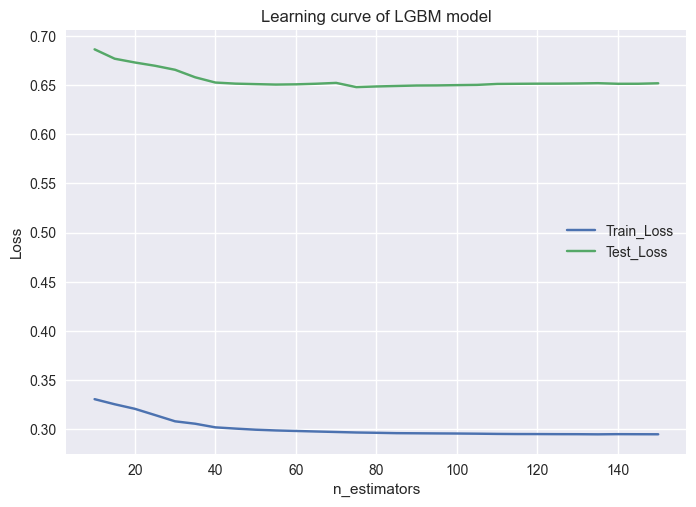

In [32]:
lgbmr_results.plot(x='n_estimators', y=['Train_Loss', 'Test_Loss'])
plt.ylabel("Loss")
plt.title("Learning curve of LGBM model")

This chart indicates that the training is quite effective. Initially, the training set provides a good learning base for the test set, especially during the early epochs (i.e., a low number of estimators), where the error reduction rate is relatively close. We observe a fairly steady progression between epochs $40$ and $70$, followed by a slight increase in error. However, at epoch $75$, we can observe a final decrease in error, marking the lowest error rate achieved in testing, after which a slight rise in testing error suggests overfitting, as the training error continues to decrease slowly.

These analyses suggest that the training dataset is quite effective for learning, but the chosen methodology hits a performance limit with an error around $0.648$. While this limit is worse than the results achieved by the competition's top team, this method would have placed us in the top $10$, specifically in the 9th position. Moreover, this solution remains relatively simple, using only the previous risk value for prediction. Considering other features for training could be beneficial, but care must be taken not to compromise the representativeness of the training set relative to the test set. On the other hand, we note that the oversampling method, SMOTE, is particularly efficient here since the best loss that we obtained without data augmentation was around $1.00$. 

Finally, it's important to note that during the competition, it wasn't possible to perform such extensive testing as there was a limit of two solution submissions per day. Therefore, it's uncertain if this exact performance could have been achieved; the likely performance would have been around $0.650$.